1. How this autoencoder helps in MVTec defect detection

The MVTec AD dataset is designed for unsupervised anomaly detection. Most categories (carpet, metal nut, toothbrush, etc.) have only normal training samples. Defects (scratches, cracks, dents, misaligned, etc.) appear only in the test set.

An autoencoder can be used like this:

Train only on normal images → The model learns to compress and reconstruct normal textures/objects.

At inference → Feed an image (normal or defective) through the autoencoder.

If it’s normal → reconstruction is good (low reconstruction error).

If it has defects → the model struggles to reconstruct defect regions, since it never saw them during training.

Defect detection → Compare input vs reconstruction using

Pixel-wise error (L2 or SSIM loss)

Feature-space error (perceptual loss with pretrained network).

This makes the autoencoder useful for localizing and scoring defects in MVTec.

## Visualizing the image

In [1]:
!tar -xf /content/bottle.tar.xz -C /content/

In [2]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def visualize_images(images, title):
  # Visualize some images
  plt.figure(figsize=(8,4))
  for i, path in enumerate(images[:4]):
      img = cv2.imread(path) # load in color (BGR)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to RGB for matplotlib
      plt.subplot(1,4,i+1)
      plt.imshow(img)  # no cmap needed
      plt.axis("off")

  plt.suptitle(title)
  plt.show()

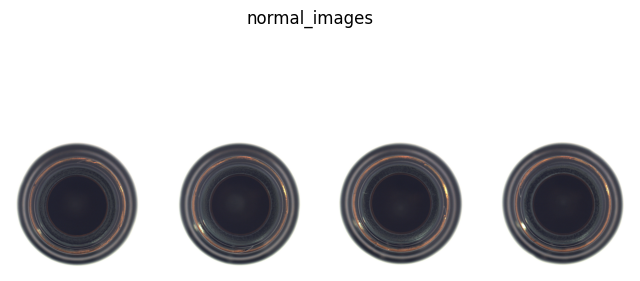

In [4]:
import glob
normal_images = glob.glob("/content/bottle/train/good/*.png") # extract pathnames with specific pattern
visualize_images(normal_images, title = "normal_images")

In [7]:

print((normal_images[0]))
img = cv2.imread(normal_images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)

/content/bottle/train/good/030.png
(900, 900, 3)


In [5]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchsummary import summary
from torch.utils.data.dataset import Subset
from torch import nn

In [8]:
from torchvision.transforms import transforms
from PIL import Image
# Define the transformation pipeline using torchvision.transforms.Compose
transform = transforms.Compose([
    transforms.Resize((224,224)),       # resize images
    transforms.RandomHorizontalFlip(),  # randomly flip images
    transforms.RandomRotation(15),      # rotate +/-15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),              # convert to tensor
])
# Convert NumPy array to PIL Image
img = Image.fromarray(img)
# Apply the defined transformation pipeline to the image
img = transform(img)
# Print the shape of the transformed image tensor
print(img.shape)

torch.Size([3, 224, 224])


In [9]:
from torchvision.datasets import ImageFolder
# Define the path to the directory containing the train images
train_image_path = 'bottle/train'
'''
Load the train dataset using the ImageFolder dataset class
ImageFolder is a PyTorch dataset class for loading images from a directory
It automatically loads images from subdirectories and applies transformations to them
In this case, 'transform' is a transformation applied to each image in the dataset
It preprocesses the images before they are used for training
'''
good_dataset = ImageFolder(root=train_image_path, transform=transform)
'''
Access a sample from the dataset
In this case, we're accessing the first sample
x contains the preprocessed image data
y contains the corresponding label (class index)
'''
x, y = good_dataset[0]
# Print the shape of the preprocessed image data (x) and its corresponding label (y)
print("Image Shape:", x.shape)
print("Label:", y)

Image Shape: torch.Size([3, 224, 224])
Label: 0


## Train test split for the autoencoder

In [10]:
'''
Split the dataset into training and testing subsets
The `torch.utils.data.random_split` function randomly splits a dataset into non-overlapping subsets
The first argument `good_dataset` is the dataset to be split
The second argument `[0.8, 0.2]` specifies the sizes of the subsets. Here, 80% for training and 20% for testing.
'''
train_dataset, test_dataset = torch.utils.data.random_split(good_dataset, [0.8, 0.2])

# Print the lengths of the original dataset, training subset, and testing subset
print("Total number of samples in the original dataset:", len(good_dataset))
print("Number of samples in the training subset:", len(train_dataset))
print("Number of samples in the testing subset:", len(test_dataset))

Total number of samples in the original dataset: 209
Number of samples in the training subset: 168
Number of samples in the testing subset: 41


### Using dataloader for efficient data loading during training

Shape of input images: torch.Size([16, 3, 224, 224])
Shape of labels: torch.Size([16])


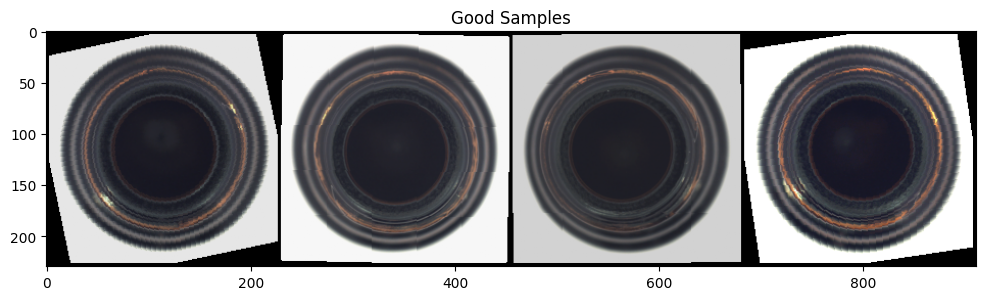

In [11]:
import torch
from torch.utils.data import DataLoader
# Assuming train_dataset and test_dataset are PyTorch datasets containing image data and labels

# Set the batch size
BS = 16

# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=True)

# Get a batch of images and labels from the training loader
image_batch, label_batch = next(iter(train_loader))

# Print the shape of the input images and labels
print('Shape of input images:', image_batch.shape)
print(f'Shape of labels: {label_batch.shape}')

# Set the figure size
plt.figure(figsize=(12, 4))
# Create a grid of images from the image batch and visualize it
grid = torchvision.utils.make_grid(image_batch[0:4], padding=3, nrow=4)
plt.imshow(grid.permute(1, 2, 0))  # Permute dimensions to (height, width, channels) for visualization
plt.title('Good Samples')  # Set the title of the plot
plt.show()  # Show the plot

you can use this formula [(W−K+2P)/S]+1.

W is the input volume - in your case 224
K is the Kernel size - in your case 4
P is the padding - in your case 0 i believe
S is the stride - which you have not provided.
So, we input into the formula:

Output_Shape = (224-4+0)/1+1

Output_Shape = (221,221,128)
 128 - number of filters

## Train autoencoder model

In [13]:
import torch.nn.functional as F
from torch import nn

input_image = Image.open("/content/bottle/train/good/000.png")
input_image = transform(input_image) # resizes the image, converts to a tensor

input_image = input_image.unsqueeze(0) # adds an extra dimension (represnting batch size)
# print(input_image.shape)


c1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4)
x = c1(input_image)
print(x.shape)
ap1 = nn.AvgPool2d(kernel_size=2, stride=2 )
x = ap1(x)
print(x.shape)
c2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4)
ap2 = nn.AvgPool2d(kernel_size=2, stride=2 )
x= ap2(c2(x))
print(x.shape)
c3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3 )
ap3 = nn.AvgPool2d(kernel_size=2, stride=2 )
x = ap3(c3(x))
print(x.shape)

c4 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, output_padding=1 )
x = c4(x)
print(x.shape)
c5 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=5, stride=2, output_padding=1 )
x = c5(x)
print(x.shape)
c6 = nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=5, stride=2, output_padding=1 )
x = c6(x)
print(x.shape)



torch.Size([1, 128, 221, 221])
torch.Size([1, 128, 110, 110])
torch.Size([1, 256, 53, 53])
torch.Size([1, 256, 25, 25])
torch.Size([1, 256, 53, 53])
torch.Size([1, 128, 110, 110])
torch.Size([1, 3, 224, 224])


In [14]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, output_padding=1 ),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=5, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Test the autoencoder architecture
model = Autoencoder()
input_image = torch.randn(1, 3, 224, 224)  # Sample input image
output_image = model(input_image)
print(output_image.shape)  # Print the shape of the output image

torch.Size([1, 3, 224, 224])


In [15]:
# Define the loss function and optimizer

model.cuda()# Move the model to the GPU

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [16]:
model = model.cuda()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/25], Loss: 0.0560, Validation Loss: 0.0652
Epoch [6/25], Loss: 0.0236, Validation Loss: 0.0224
Epoch [11/25], Loss: 0.0157, Validation Loss: 0.0171
Epoch [16/25], Loss: 0.0125, Validation Loss: 0.0160
Epoch [21/25], Loss: 0.0166, Validation Loss: 0.0143


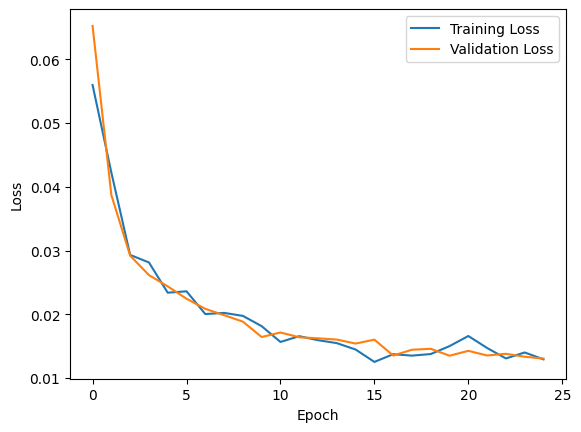

In [17]:
# Define a list to store training loss and validation loss
Loss = []
Validation_Loss = []


num_epochs = 25
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set model to training mode
    for img, _ in train_loader:
        img = img.cuda()

        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad() #clears the gradients of all optimized tensors.  This step is necessary because gradients are accumulated by default in PyTorch, and we want to compute fresh gradients for the current batch of data.
        loss.backward() # This line computes the gradients of the loss function with respect to the model parameters. These gradients are used to update the model parameters during optimization.
        optimizer.step() # This line updates the model parameters using the computed gradients.
    Loss.append(loss.item())


    # Calculate validation loss
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for img, _ in test_loader:
            img = img.cuda()
            output = model(img)
            val_loss = criterion(output, img)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)

    if epoch % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss_avg))

plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Reconstruction of good images

torch.Size([16, 224, 224])


<Figure size 1600x1200 with 0 Axes>

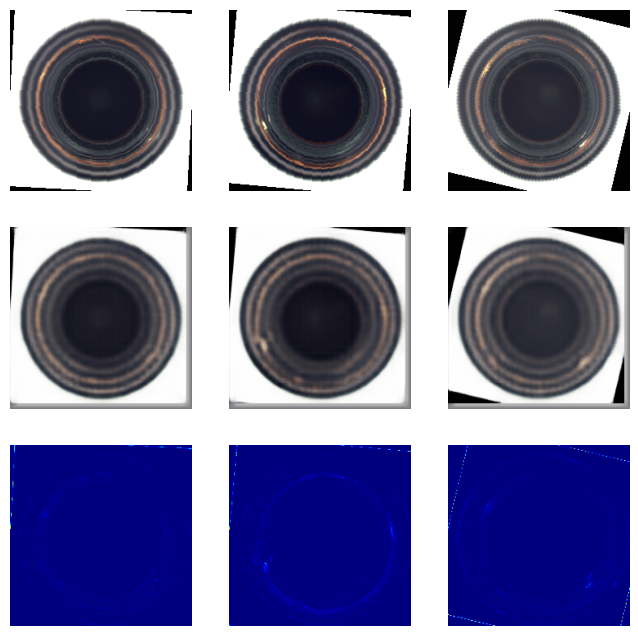

In [18]:
with torch.no_grad():
    for data, _ in train_loader:
        data = data.cuda()
        recon = model(data)
        break

recon_error =  ((data-recon)**2).mean(axis=1)
print(recon_error.shape)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i])) #[0:-10,0:-10]
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()

## Obtain the fault detection HEATMAP using AE

<Figure size 1600x1200 with 0 Axes>

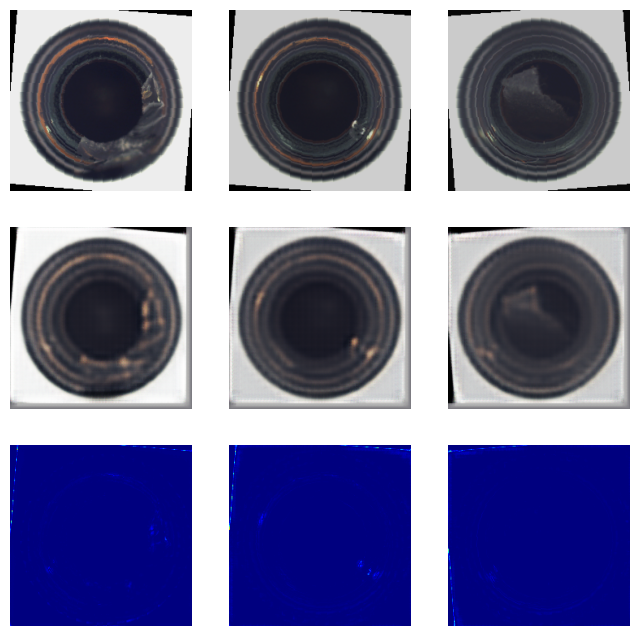

In [19]:
test_image_1 = transform(Image.open("/content/bottle/test/broken_large/000.png"))
test_image_2 = transform(Image.open("/content/bottle/test/broken_small/000.png"))
test_image_3 = transform(Image.open("/content/bottle/test/contamination/000.png"))

data = torch.stack([test_image_1,test_image_2, test_image_3])

with torch.no_grad():
    data = data.cuda()
    recon = model(data)

recon_error =  ((data-recon)**2).mean(axis=1)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i]))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()

## Obtain the fault detection accuracy

In [20]:
RECON_ERROR=[]
with torch.no_grad():
    for data, _ in train_loader:
        data = data.cuda()
        recon = model(data)
        data_recon_squared_mean =  ((data-recon)**2).mean(axis=(1))[:,0:-10,0:-10].mean(axis=(1,2))

        RECON_ERROR.append(data_recon_squared_mean)

RECON_ERROR = torch.cat(RECON_ERROR).cpu().numpy()

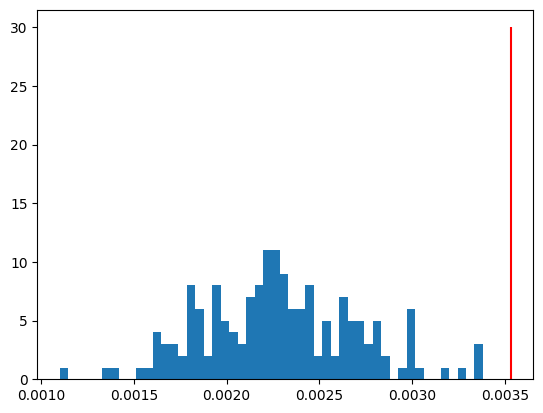

In [22]:
best_threshold = np.mean(RECON_ERROR) + 3 * np.std(RECON_ERROR)

plt.hist(RECON_ERROR,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

In [23]:
y_true=[]
y_pred=[]
y_score=[]

model.eval()

with torch.no_grad():

    test_path = Path('bottle/test')

    for path in test_path.glob('*/*.png'):
        fault_type = path.parts[-2]
        # if fault_type != 'good':
        test_image = transform(Image.open(path)).cuda().unsqueeze(0)
        recon_image = model(test_image)

        # y_score_image =
        y_score_image =  ((test_image - recon_image)**2).mean(axis=(1))[:,0:-10,0:-10].mean()

        y_pred_image = 1*(y_score_image >= best_threshold)

        y_true_image = 0 if fault_type == 'good' else 1

        y_true.append(y_true_image)
        y_pred.append(y_pred_image.cpu())
        y_score.append(y_score_image.cpu())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

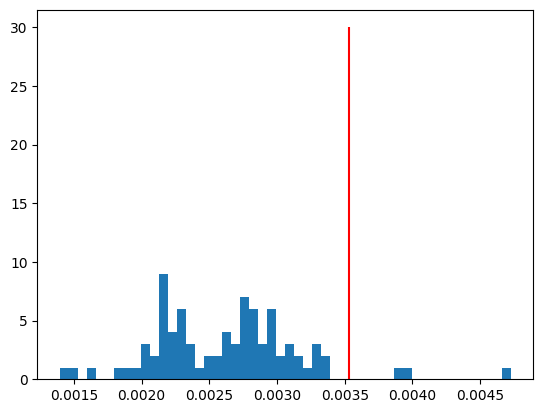

In [24]:
plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

AUC-ROC Score: 0.5111111111111111


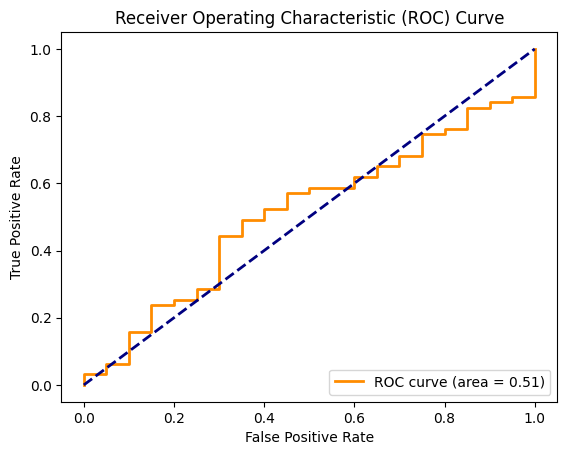

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns



# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

1️⃣ Potential reasons for low AUROC

Reconstruction too coarse

Your encoder + decoder may blur fine details.

Tiny defects in MVTec (scratches, dents) are lost → low reconstruction error → low anomaly score.

Bottleneck too small or too compressed

Too much compression can remove too much detail, but sometimes too little compression makes reconstruction too easy → model reconstructs defects too well.

No skip connections

Vanilla autoencoder tends to lose spatial information, especially fine textures.

Defects aren’t localized → reconstruction error is low → AUROC suffers.

Loss function

Standard MSE loss may not be sensitive to small local defects.

Small differences may be ignored in pixel-wise MSE.

Insufficient training

25 epochs may be too few for complex datasets like MVTec.

Learning rate, optimizer, and batch size could also affect convergence.

Input preprocessing

Images may need normalization and resizing.

Defects may be too small relative to input resolution (e.g., 224×224 might be okay, but pooling reduces feature map size too quickly).